## Imports

In [77]:
import os
import glob

#imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#Image processing
import cv2 as cv

#tensorflow 
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator

In [2]:
#Dataframe classifying the actions
train_action = pd.read_csv("data/Training_set.csv")
test_action = pd.read_csv("data/Testing_set.csv")

In [3]:
train_action.head()

,filename,label
0,Image_1.jpg,sitting
1,Image_2.jpg,using_laptop
2,Image_3.jpg,hugging
3,Image_4.jpg,sleeping
4,Image_5.jpg,using_laptop


## Looking at the data

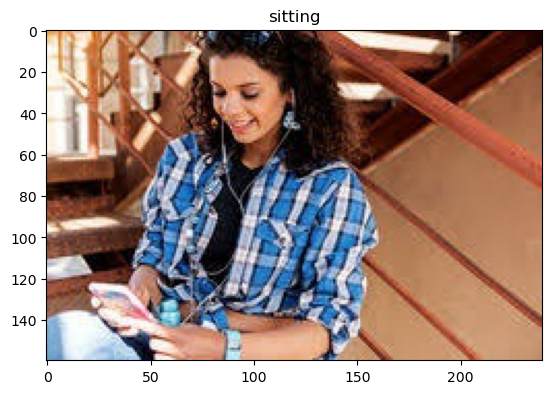

In [4]:
#Printing the images along with their respective action

img = cv.imread('data/train/' + train_action.filename[0])
plt.title(train_action.label[0])
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB));

In [5]:
test_action.shape

(5400, 1)

There are 12,600 images in the training dataset. Creating a function which will randomly sample a image from the set and print the image along with its labeled action.

In [6]:
#Sample images and their labels in the training data


def show_img_train():
    img_num = np.random.randint(0,12599)
    img = cv.imread('data/train/' + train_action.filename[img_num])
    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.title(train_action.label[img_num])

def show_img_test():
    img_num = np.random.randint(0,5399)
    img = cv.imread('data/test/' + test_action.filename[img_num])
    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))

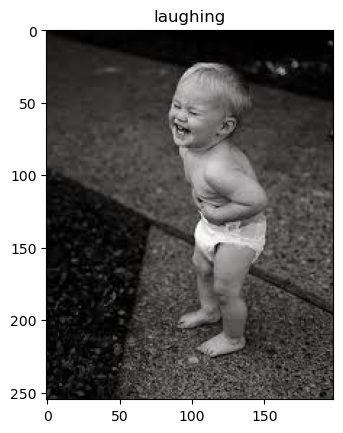

In [7]:
show_img_train()

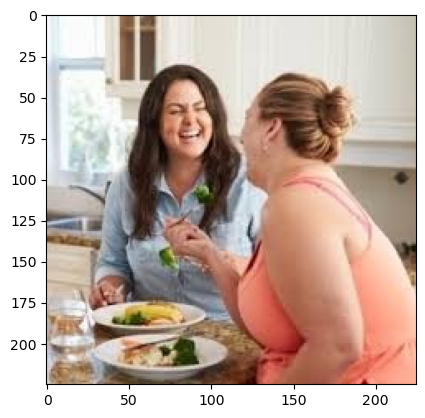

In [8]:
show_img_test()

Note that the images from the test set do not contain the labels. That is for the model to predict.

In [9]:
train_action.label.value_counts()

sitting               840
using_laptop          840
hugging               840
sleeping              840
drinking              840
clapping              840
dancing               840
cycling               840
calling               840
laughing              840
eating                840
fighting              840
listening_to_music    840
running               840
texting               840
Name: label, dtype: int64

The output classes for the image classification are balanced. This reduces a step in pre-processing which deals with imbalanced classes using techniques such as SMOTE, under-sampling, etc.

## Preprocessing

(160, 240, 3)


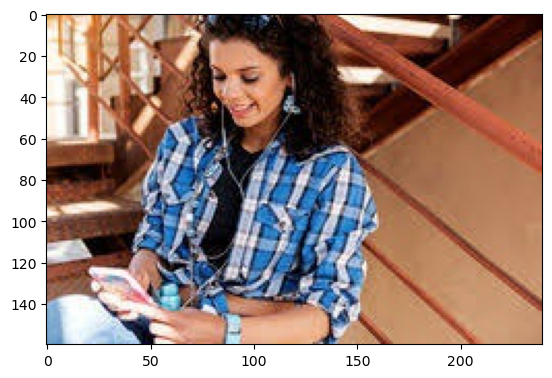

In [10]:
img = cv.imread('data/train/' + train_action.filename[0])
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB));
print(img.shape)

### Create the directory for resized images 

Skipping the below cell since the folder has already been created.

In [31]:
#create resized directory in the current project folder
parent_dir = os.getcwd()
directory = 'resized-train'
path = os.path.join(parent_dir, directory)
os.mkdir(path)
print('Created "resized-train" folder')

Created "resized-train" folder


## Resize the training images

In [32]:
#dimensions
width = 224
height = 224
dim = (width, height)

#resizing all the images in the train folder
for i in np.arange(len(train_action.filename)):    
    #read the filename from the dataframe
    filename = train_action.filename.iloc[i]
    #read the image from the train folder
    img = cv.imread('data/train/' + filename)
    #resize the image
    resized = cv.resize(img, dim, interpolation = cv.INTER_AREA)
    #write the image in resized folder
    cv.imwrite('./resized-train/' + filename ,resized)

## Resize the test set images

In [33]:
#create resized directory in the current project folder
parent_dir = os.getcwd()
directory = 'resized-test'
path = os.path.join(parent_dir, directory)
os.mkdir(path)
print('Created "resized-test" folder')

Created "resized-test" folder


In [34]:
#resizing all the images in the train folder
for i in np.arange(len(test_action.filename)):    
    #read the filename from the dataframe
    filename = test_action.filename.iloc[i]
    #read the image from the train folder
    img = cv.imread('data/test/' + filename)
    #resize the image
    resized = cv.resize(img, dim, interpolation = cv.INTER_AREA)
    #write the image in resized folder
    cv.imwrite('./resized-test/' + filename ,resized)

## Pre-processing

### Display image

(224, 224, 3)


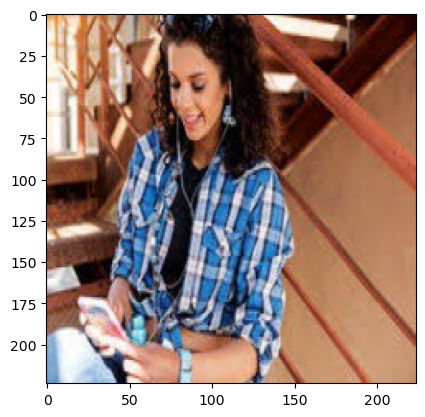

In [40]:
img = cv.imread('resized-train/' + train_action.filename[0])
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
print(img.shape)

## Read images and convert them into numpy arrays

In [72]:
#empty list train
X_train = []

#reading all the resized images
for i in np.arange(len(train_action.filename)): 
    img = cv.imread('resized-train/' + train_action.filename[i])
    X_train.append(img)

X_train = np.asarray(X_train)
X_train.shape

(12600, 224, 224, 3)

In [73]:
#empty list test
X_test = []

#reading all the resized images
for i in np.arange(len(test_action.filename)): 
    img = cv.imread('resized-test/' + test_action.filename[i])
    X_test.append(img)

X_test = np.asarray(X_test)
X_test.shape

(5400, 224, 224, 3)

### Processing Labels 

In [74]:
y_train = np.asarray(pd.get_dummies(train_action.label))
print(y_train.shape)

(12600, 15)


## Building the CNN model using transfer learning

### Initializing a VGG16 model

In [78]:
#Sequential model constructor
cnn_model = Sequential()

#initializing a vgg16 wihtout the top layers 
pretrained_model= tf.keras.applications.VGG16(include_top=False,
                   input_shape=(224,224,3),
                   pooling='avg',classes=15,
                   weights='imagenet')

#Freezing the deeper layers
for layer in pretrained_model.layers:
        layer.trainable=False
        
#adding our layers to the model
cnn_model.add(pretrained_model)
cnn_model.add(Flatten())
cnn_model.add(Dense(512, activation='relu'))
cnn_model.add(Dense(15, activation='softmax'))

Metal device set to: Apple M1 Pro


2022-09-25 16:16:40.188612: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-09-25 16:16:40.188955: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [79]:
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

In [80]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dense_1 (Dense)             (None, 15)                7695      
                                                                 
Total params: 14,985,039
Trainable params: 270,351
Non-trainable params: 14,714,688
_________________________________________________________________


In [86]:
#Saving the trained weights
cnn_model.save_weights('./model/cnn_model.h5')

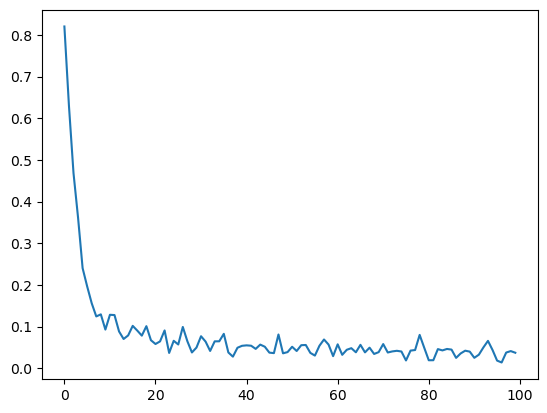

In [87]:
#plotting the loss
loss = history.history['loss']
plt.plot(loss)

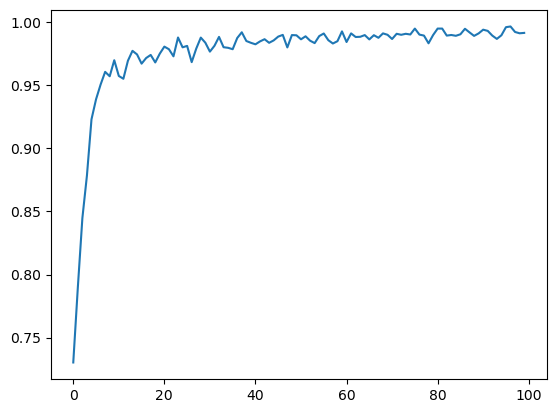

In [88]:
accu = history.history['accuracy']
plt.plot(accu)